In [1]:
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
import numpy as np
import pandas as pd
import glob
import math
from datetime import date
from functools import partial
import matplotlib.pyplot as plt
from matplotlib import colors
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': '16'})
import warnings; warnings.simplefilter('ignore')


# Parallel Programming with Python
_Thomas Langford, Ph.D._

_Yale Center for Research Computing_

_November 15, 2023_


# Tools and Requirements

- Language: Python 3.8
- Modules: `pandas`, `numpy`, `multiprocessing` (parallelism on local machines), `joblib`, `dask` and `dask-distributed`, `PIL` (for imamge processing), `mpi4py` (for more advanced copied), `matplotlib`, `cupy` (for GPU parallelism)
- Jupyter notebook

# How to Follow Along

## Clone from GitHub

Navigate to the GitHub repository: https://github.com/ycrc/parallel_python

![qr](parallel_python.png)

Clone or download the zip file that contains this notebook and required data.


# Outline and Overview

- Serial vs Parallel Algorithms
- Python implementations of parallelism
    - Single node 
    - Multi-node on YCRC Clusters
- GPU Parallelism with NVIDIA GPUs
- Tools for further exploration


# Introduction to parallel concepts



In [ ]:
https://mybinder.org/v2/gh/ycrc/parallel_python/master 

## Serial Execution
Typical programs operate lines sequentially:

In [2]:
# Define an array of numbers
foo = np.array([0, 1, 2, 3, 4, 5])

# Define a function that squares numbers
def bar(x):
    return x * x

# Loop over each element and perform an action on it
for element in foo:

        # Print the result of bar
        print(bar(element))

0
1
4
9
16
25


## The `map` function

A key tool that we will utilize later is called `map`. This lets us apply a function to each element in a list or array:

In [3]:
# (Very) inefficient way to define a map function
def my_map(function, array):
    # create a container for the results
    output = []

    # loop over each element
    for element in array:
        
        # add the intermediate result to the container
        output.append(function(element))
    
    # return the now-filled container
    return output


In [4]:
my_map(bar, foo)

[np.int64(0),
 np.int64(1),
 np.int64(4),
 np.int64(9),
 np.int64(16),
 np.int64(25)]


Python has a helpfully provided a `map` function in the standard library:

In [5]:
list(map(bar, foo))

# NB: in python3 `map` is a generator, so we need to cast it to a list for this comparison

[np.int64(0),
 np.int64(1),
 np.int64(4),
 np.int64(9),
 np.int64(16),
 np.int64(25)]

The built-in `map` function is much more flexible and featured than ours, so it's best to use that one instead. 

## Parallel Workers

In the example we showed before, no step of the `map` call depend on the other steps. 

Rather than waiting for the function to loop over each value, we could create multiple instances of the function `bar`  and apply it to each value simultaneously.

This is achieved with the `multiprocessing` module and a pool of workers.



## The `Mutiprocessing` module

The `multiprocessing` module has a number of functions to help simplify parallel processing.

One such tool is the `Pool` class. It allows us to set up a group of processes to excecute tasks in parallel. This is called a pool of worker processes. 

First we will create the pool with a specified number of workers. We will then use our `map` utility to apply a function to our array. 

In [7]:
import joblib
joblib.Parallel(n_jobs=4)(joblib.delayed(bar)(i) for i in foo)

[np.int64(0),
 np.int64(1),
 np.int64(4),
 np.int64(9),
 np.int64(16),
 np.int64(25)]

In [13]:
import multiprocessing

# Create a pool of processes
with multiprocessing.Pool(processes=6) as pool:
    # map the `np.square` function on our `foo` array
    result = pool.map(np.square, foo)

# output the results
print(result)


[np.int64(0), np.int64(1), np.int64(4), np.int64(9), np.int64(16), np.int64(25)]


The difference here is that each element of this list is being handled by a different process. 



To show how this is actually being handled, let's create a new function:

In [9]:
def parallel_test(x):
    # print the index of the job and it's process ID number
    s = f"x = {x}, PID = {os.getpid()}"
    print(s)
    return s

Now we can map this function on the `foo` array from before. First with the built-in `map` function:

In [10]:
list(map(parallel_test, foo));

x = 0, PID = 9296
x = 1, PID = 9296
x = 2, PID = 9296
x = 3, PID = 9296
x = 4, PID = 9296
x = 5, PID = 9296


We see that each step is being handled by the same process and are excecuted in order.

Now we try the same process using `multiprocessing`:

In [ ]:
with multiprocessing.Pool(processes=6) as pool:
    result = pool.map(parallel_test, foo)

# This is taking me way too long to figure out:
# Apparently, according to a medium article: "If we selected the easiest computation with a multiprocessor pool it does not use multiprocessors. Array size or input data type doesn’t matter."
# According to Claude: "on windows python uses a method called "spawn" where each worker re-imports all modules every time,
# the python interpreter restarts fresh for each process and the overhead is incurred every time the pool is created. " 
# A solution to this is to use joblib which reuses workers more efficiently


: 

: 

In [ ]:
%%timeit

joblib.Parallel(n_jobs=4)(joblib.delayed(bar)(i) for i in foo)

12.1 ms ± 361 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Two things are worth noting:
1. Each element is processed by a different PID
2. The tasks are not executed in order!


## Key Take-aways

1. The `map` function is designed to apply the same function to each item in an iterator
2. In serial processing, this works like a for-loop
3. Parallel execution sets up multiple worker processes that act separately and simultaneously

## Example 1: Monte Carlo Pi Calculation

- Run multiple instances of the same simulation with different random number generator seeds
- Define a function to calculate `pi` that takes the random seed as input, then map it on an array of random seeds

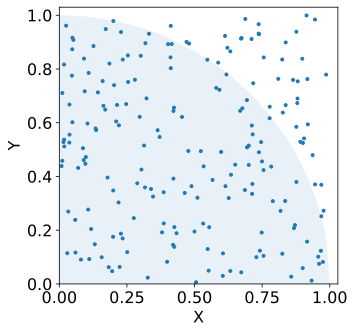

In [10]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(5,5))
x = np.linspace(0,1,100)
plt.fill_between(x, np.sqrt(1-x**2),0,alpha=0.1)
plt.xlim(0,1.03);plt.ylim(0,1.03);plt.xlabel('X');plt.ylabel('Y');

x = np.random.random(size=200)
y = np.random.random(size=200)

plt.plot(x,y,marker='.',linestyle='None');


In [11]:
def pi_mc(seed):
    num_trials = 500000 
    counter = 0
    np.random.seed(seed)
    
    for j in range(num_trials):
        x_val = np.random.random_sample()
        y_val = np.random.random_sample()

        # Calculate pi by calculating the radius of a cicle and everything inside that radius counts towards pi

        radius = x_val**2 + y_val**2

        if radius < 1:
            counter += 1
            
    return 4*counter/num_trials

### Serial vs Parallel

In [12]:
%timeit pi_mc(1)

730 ms ± 117 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
# now we can have multiple seeds so that we can run these simulations in parallel  
seed_array = list(range(4))
%timeit list(map(pi_mc, seed_array))

# here when we run the serial version is basically takinf 4 times as long as the single version, so what we would expect.

2.88 s ± 521 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit

with multiprocessing.Pool(processes=4) as pool:
    result = pool.map(pi_mc, seed_array)

In [15]:
%%timeit

joblib.Parallel(n_jobs=4)(joblib.delayed(pi_mc)(i) for i in seed_array)

871 ms ± 22.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


While the serial execution scales up linearly (~4x longer than one loop), the parallel execution doesn't quite reach the single iteration performance. There is some overhead in setting up the threads that needs to be considered.

## `joblib` parallel for-loops

_https://joblib.readthedocs.io_

- `joblib` simplifies the creation of pipelines which can orchestrate multi-step analyses. 
- It can also simply manage embarassingly parallel problems much like `multiprocessing`. 

In [16]:
import joblib

In [ ]:
joblib.Parallel(n_jobs=4)(joblib.delayed(pi_mc)(i) for i in range(10))

[3.139272,
 3.1424,
 3.144096,
 3.141536,
 3.135888,
 3.137824,
 3.141552,
 3.141672,
 3.141992,
 3.142352]

## Example 2: Processing multiple input files

Say we have a number of input files, like `.jpg` images, that we want to perform the same actions on, like rotate by 180 degrees and convert to a different format. 

We can define a function that takes a file as input and performs these actions, then map it on a list of files.


In [17]:
# import python image library functions
from PIL import Image

from matplotlib.pyplot import imshow
%matplotlib inline

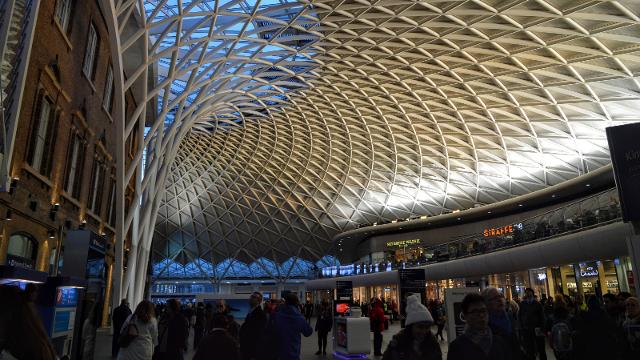

In [18]:
#Read image
im = Image.open( './data/kings_cross.jpg' )
#Display image
im

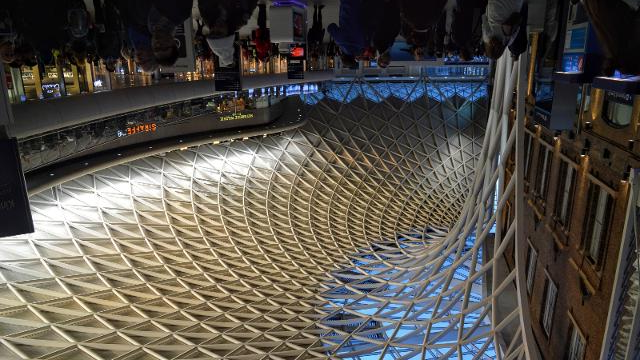

In [19]:
im.rotate(angle=180)

Let's define a function that takes a file name as input, opens the file, rotates it upside down, and then saves the output as a PDF:

In [20]:
def image_flipper(file_name):
    # extract the base file name
    base_name = file_name[0:-4]
    
    # opens the file
    im = Image.open( file_name )

    # rotates by 180deg
    im_flipped = im.rotate(angle=180)
    
    # Saves a PDF output with a new file name
    im_flipped.save(base_name + "_flipped.pdf", format='PDF')

    return base_name + "_flipped.pdf"

In [21]:
file_list = glob.glob('./data/*jpg')

for f in file_list:
    print(f)

./data\charing_cross.jpg
./data\euston.jpg
./data\fenchurch.jpg
./data\kings_cross.jpg
./data\liverpool_street.jpg
./data\london_bridge.jpg
./data\paddington.jpg
./data\st_pancras.jpg
./data\victoria.jpg
./data\waterloo.jpg


In [22]:
joblib.Parallel(n_jobs=4)(joblib.delayed(image_flipper)(f) for f in file_list)
# the number of processes/jobs do not need to match the number of files, it just limits the amount of parallelism
# os.path.basename aleways better

['./data\\charing_cross_flipped.pdf',
 './data\\euston_flipped.pdf',
 './data\\fenchurch_flipped.pdf',
 './data\\kings_cross_flipped.pdf',
 './data\\liverpool_street_flipped.pdf',
 './data\\london_bridge_flipped.pdf',
 './data\\paddington_flipped.pdf',
 './data\\st_pancras_flipped.pdf',
 './data\\victoria_flipped.pdf',
 './data\\waterloo_flipped.pdf']

We have created a set of PDF files with new file names and inverted images. 

In [ ]:
%ls ./data/*pdf

# number of cores that is available
joblib.cpu_count()
# goood to not use every core, so remove 1 or 2 cores
# in a cluster, it would be the number of CPUs you request from SLURM 

Parameter format not correct - "data".


12

![](./data/euston_flipped.pdf)

## Key Take-aways
1. These problems are essentially independent and share no information between them.
2. The `multiprocessing` and `joblib` modules makes it simple to run these steps together with a single command
3. This workflow is limited to running on a single computer (or compute node) since there is no mechanism to communicate outside

# Embarassingly Parallel Processing on the Clusters


We can employ these tools and techniques to run parallel workers on the large-scale computing clusters maintained by YCRC. 

We highly recommend utilizing a tool called `Dead Simple Queue`.

## Dead Simple Queue

Similar to the `map` functionality discussed earlier is the Dead Simple Queue (`dSQ`, [docs](https://docs.ycrc.yale.edu/clusters-at-yale/job-scheduling/dsq/)) module available on each cluster. 
    
    module load dSQ

With this we have access to a simple way to map a function across a job array. 

The basic idea is similar to `map`: create a list of parameters and pass them to a single function for processing. 

However, instead of doing this from within `python`, we leverage the Slurm job scheduler to divy jobs to workers. 

The key is the `jobfile`. Each line of this text file is a separate command-line job that we want to pass to a different worker. 

## dSQ Example 1: Flipping Images

We can extend the example from before to be deployed on the clusters.

Our python script (`image_flipper.py`) now looks like this:

```python    

    from PIL import Image
    from sys import argv
    
    # get the command line argument (argv[0] is the function name, argv[1] is the first argument)
    file_name = argv[1]
    
    # extract the base file name
    base_name = file_name.split('.')[0]
    
    # opens the file
    im = Image.open( file_name )

    # rotates by 180deg
    im_flipped = im.rotate(angle=180)
    
    # Saves a PDF output with a new file name
    im_flipped.save(base_name + "_flipped.pdf")
```


Then we need to create the `jobfile.txt`:


In [ ]:
for file_name in file_list:
    print(f'python image_flipper.py {file_name}')

# This is a list  independent jobs that we want SLURM to run
# if there are multiple stages, we can put a semicolon here and then it would be python stage_2.py and then the file  


python image_flipper.py ./data/charing_cross.jpg
python image_flipper.py ./data/euston.jpg
python image_flipper.py ./data/fenchurch.jpg
python image_flipper.py ./data/kings_cross.jpg
python image_flipper.py ./data/liverpool_street.jpg
python image_flipper.py ./data/london_bridge.jpg
python image_flipper.py ./data/paddington.jpg
python image_flipper.py ./data/st_pancras.jpg
python image_flipper.py ./data/victoria.jpg
python image_flipper.py ./data/waterloo.jpg


This can then be saved (`jobfile.txt`) passed to dSQ:

    dSQ --jobfile jobfile.txt --cpus-per-task=1 --mem-per-cpu=5G --time=2:00:00
    
Which outputs a Slurm submission script:

    #!/bin/bash
    #SBATCH --array 0-9
    #SBATCH --output dsq-jobfile-%A_%1a-%N.out
    #SBATCH --job-name dsq-jobfile
    #SBATCH --cpus-per-task=1 --mem-per-cpu=5G --time=2:00:00

    # DO NOT EDIT LINE BELOW
    /vast/palmer/apps/avx2/software/dSQ/1.05/dSQBatch.py --job-file 
    /vast/palmer/home.grace/tl397/ycrc/workshops/parallel_python/jobfile.txt --status-dir /vast/palmer/home.grace/tl397/ycrc/workshops/parallel_python

We can either save this output as a sbatch submission script (and then run it: `sbatch run.sh`), or we can add the ``--submit`` flag to the dSQ command which will automatically submit the job array:

    dSQ --job-file jobfile.txt --submit
    
We can also add any further Slurm arguments that we need:

    dSQ --job-file jobfile.txt --submit --partition day -t 6:00:00 --mem-per-cpu 10000 --cpus-per-task=1

This will submit our job to the `day` partition while requesting one CPU for each task, 10GB of memory per CPU, and a wall time of 6 hours.

In [ ]:
# So basically with dSQ we can submit a whole array of jobs all at once and SLURM will know how to parallelize
# With this method, SLURM will be much more efficient because it will do overhead only once per the whole job. 
# every time you ping squeue is a database query and that takes time.

# mpi4py

MPI is a standard protocol that defines how messages are passed between processes, including one-to-one and broadcast communications. The python modul is called mpi4py.
 

# Dask

_https://docs.dask.org/_

- Flexible library for parallel computing in Python.
- Dynamic task scheduling optimized for computation. 
- “Big Data” collections like parallel arrays and dataframes extended to larger-than-memory or distributed environments

In [ ]:
import dask.dataframe as dd
import dask.array as da

In [ ]:
data = np.random.normal(size=100000).reshape(200, 500)
a = da.from_array(data, chunks=(100, 100))
a

dask.array<array, shape=(200, 500), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

In [ ]:
a[:50, 200]

dask.array<getitem, shape=(50,), dtype=float64, chunksize=(50,), chunktype=numpy.ndarray>

In [ ]:
a[:50, 100].compute()

array([-1.43243322e+00, -1.16493758e+00, -1.87967293e+00,  1.47886369e-01,
        1.28971173e+00, -5.20397767e-01,  7.38853770e-01, -6.29040623e-01,
        1.08457857e+00, -1.65313786e+00,  4.96115440e-02,  1.14667021e+00,
       -1.84882693e-01, -4.90448809e-01, -1.98556060e-01, -4.59505020e-01,
       -1.23344705e+00, -4.75947121e-01, -1.08411314e+00,  1.10891156e+00,
       -3.80255131e-01, -2.05722915e-01,  1.76842336e+00,  2.14955832e-01,
        4.06571959e-01,  1.07101227e+00,  1.70421791e+00, -2.57276521e+00,
        2.11179670e+00,  9.94971691e-04,  6.76553884e-02,  1.02370386e+00,
       -1.28329307e+00,  2.35121424e-01, -1.23902863e-01,  7.26158694e-01,
        1.21912210e-01,  1.06211882e+00, -5.90280767e-01,  8.41471468e-01,
       -4.44307566e-01, -2.65149637e-01,  1.28920793e+00,  1.83402709e+00,
        1.66868151e+00,  3.36507699e-01, -1.54065640e-01,  1.04694489e+00,
        4.46484496e-01, -9.05282945e-01])

In [ ]:
a.mean().compute()

0.002149433493598839

## Dask Distributed with Slurm

In [26]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

ModuleNotFoundError: No module named 'dask_jobqueue'

In [ ]:
# Define single unit of the Dask Distributed "Cluster"
cluster = SLURMCluster(queue='admintest', cores=1, memory="20GB")

# Scale up the cluster to have 12 members
cluster.scale(12)

# Initialize the "client" so that the script is connected to the Cluster
client = Client(cluster)


In [ ]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.181.185.63:8787/status,
Dashboard: http://10.181.185.63:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.181.185.63:43435,Workers: 0
Dashboard: http://10.181.185.63:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [ ]:
data = np.random.normal(size=200000000).reshape(40000, 5000)
a = da.from_array(data, chunks=(2000, 1000))
a

dask.array<array, shape=(40000, 5000), dtype=float64, chunksize=(2000, 1000), chunktype=numpy.ndarray>

In [ ]:
a.std().compute()

1.0000300879234478

## Example 3: NYC Taxi Data

- Collected data from all taxi and ride-share trips
- Very large data sets, too big to work with all at once on a single computer
- Let's use `dask` to explore some facets of the data


In [ ]:
yellow_cab = glob.glob('/home/tl397/ycrc/workshops/taxi/yellow_tripdata_2022-*parquet')
ride_share = glob.glob('/home/tl397/ycrc/workshops/taxi/fhvhv_tripdata_2022-*parquet')


In [ ]:
yc = dd.read_parquet(yellow_cab)
rs = dd.read_parquet(ride_share) 


In [ ]:
yc = yc[(yc.fare_amount > 0)]
rs = rs[(rs.base_passenger_fare > 0)]


### Question: Do people tip cabs or Ubers/Lyfts better?

In [ ]:
h_yc, bins = da.histogram(np.divide(yc.tip_amount, yc.fare_amount), bins=200, range=[0.01, 2])
h_rs, bins = da.histogram(np.divide(rs.tips, rs.base_passenger_fare), bins=200, range=[0.01, 2])


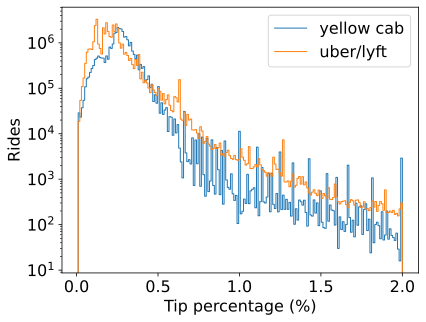

In [ ]:
plt.subplots(1,1)
plt.stairs(h_yc, bins, label="yellow cab")
plt.stairs(h_rs, bins, label="uber/lyft")

plt.yscale('log');
plt.ylabel('Rides');
plt.xlabel('Tip percentage (%)');
plt.legend();

### Mean tip percentage

In [ ]:
print(f"Yellow Cab: {100*yc.tip_amount.divide(yc.fare_amount).mean().compute():.2f}%")

Yellow Cab: 22.52%


In [ ]:
print(f"Ride-share: {100*rs.tips.divide(rs.base_passenger_fare).mean().compute():.2f}%")

Ride-share: 4.40%


In [ ]:
cluster.close()

## Key Take-aways
1. Dask is able to orchestrate lots of parallel workers, either locally or across the cluster
2. It's easier to not tip when it's on an app?


# GPU Parallelism

## CPU vs GPU

- CPU (Central Processing Unit) 
    - highly flexible computing elements, capable of doing any task required
    - Few very fast cores with large slow-access memory

- GPU (Graphics Processing Unit):
    - developed to handle very specific tasks, like ray-tracing and image rendering
    - 1000s of cores with small high-speed memory

- Some problems can be effectively split across the GPU cores for incredible speed-ups

## Vectorized Functions

- Vectorization: Applying the same function to every element of an array
- Example 1: Operate a function on each element of an array
- Example 2: matrix multiplication with large matrices (10k x 10k)


## GPUs on the Clusters

- We have a collection of GPUs available on Farnam and Grace
- Requesting these resources is straightforward ([YCRC docs](http://docs.ycrc.yale.edu/clusters-at-yale/job-scheduling/resource-requests/#request-gpus)), and only envolves adding a few flags to your `salloc` or `sbatch` commands:

`salloc --x11 -p gpu_devel -t 2:00:00 --gpus=1`

- This will request one GPU (a "general resource" or `gres`) from the `gpu_devel` partition
- Similar commands can be added to batch SLURM scripts and run on the `gpu` partition

## PyCUDA
_https://documen.tician.de/pycuda/_

- Python connection to NVIDIA's CUDA GPU framework
- Low-level code written in C++, but all the mess is abstracted away
- Still rather complex to work with, but very powerful

## Cupy

_https://docs-cupy.chainer.org/en/stable/_

- Drop-in replacement for numpy (fully compatible API)
- Allows for near seamless GPU-based computation 
- Matrix multiplication, vector operations, etc.

Easily installed via `conda` after loading the `CUDA` module on the clusters


In [ ]:
# Load CUPY module
import cupy as cp

First, let's define a test routine with `numpy`

In [ ]:
%%timeit

# Create 2D numpy arrays
a = np.random.random(25000000)
a = a.reshape(5000,5000)

b = np.random.random(25000000)
b = b.reshape(5000,5000)

# Matrix Mult
out = np.matmul(a,b)


3.75 s ± 784 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now, let's perform the same code but running the multiplication on the GPU

In [ ]:
%%timeit

# Create 2D numpy arrays
a = np.random.random(25000000)
a = a.reshape(5000,5000)

b = np.random.random(25000000)
b = b.reshape(5000,5000)

# Move to GPU
g = cp.asarray(a)
h = cp.asarray(b)

# Matrix Mult
out = cp.matmul(g,h)

468 ms ± 881 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Considerablly faster matrix multiplication without any complicated parallel work!

## Example 4: NYC Taxi Cab Data (again)

### Load data using Pandas
Pandas has very friendly tools for reading data, we will use the `read_parquet` method to read our Taxi Cab data before converting it to numpy arrays

In [ ]:
february = pd.read_parquet('../taxi/yellow_tripdata_2022-02.parquet')
august = pd.read_parquet('../taxi/yellow_tripdata_2022-08.parquet')

In [ ]:
tip_feb = np.array(february['tip_amount'])
distance_feb = np.array(february['trip_distance'])

tip_aug = np.array(august['tip_amount'])
distance_aug = np.array(august['trip_distance'])

### Move data to GPU

Cupy has built-in tools to move data to and from GPUs, `cp.asarray()` and `cp.asnumpy`. We will use these to analyze data from the Taxi Cab dataset.

In [ ]:
gpu_tip_feb = cp.asarray(tip_feb)
gpu_dist_feb = cp.asarray(distance_feb)

gpu_tip_aug = cp.asarray(tip_aug)
gpu_dist_aug = cp.asarray(distance_aug)

### Comparison of CPU and GPU performance

In [ ]:
%%timeit
np.divide(tip_feb, distance_feb)

4.52 ms ± 4.61 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit 
gpu_tip_per_mile = cp.divide(gpu_tip_feb, gpu_dist_feb)

56.7 µs ± 5.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Visualizing Results

Data have to be pulled off the GPU to be able to visualize them. 

February Average: 1.247
August Average: 1.212


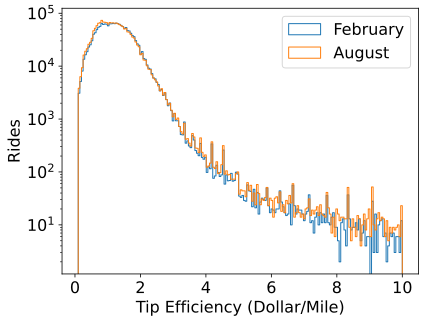

In [ ]:
gpu_tip_per_mile = cp.divide(gpu_tip_feb, gpu_dist_feb)
tpm = cp.asnumpy(gpu_tip_per_mile)[(tip_feb > 0) & (distance_feb > 1)]

plt.hist(tpm, bins=200, range=(0.1,10), histtype='step', label='February');
print(f'February Average: {np.mean(tpm[(tpm>0)&(tpm<10)]):.3f}')

gpu_tip_per_mile = cp.divide(gpu_tip_aug, gpu_dist_aug)
tpm = cp.asnumpy(gpu_tip_per_mile)[(tip_aug > 0) & (distance_aug > 1)]

plt.hist(tpm, bins=200, range=(0.1,10), histtype='step', label='August');
print(f'August Average: {np.mean(tpm[(tpm>0)&(tpm<10)]):.3f}')

plt.xlabel('Tip Efficiency (Dollar/Mile)');plt.ylabel('Rides');plt.yscale('log');plt.legend();

## GPU Summary

- There are a ton of exciting projects that are starting to utilize GPUs. 
- Having python connection to these tools enable rapid work with machine learning or other computationally intensive tasks
- Make use of the GPUs in the clusters to get started with this kind of tool

# Outlook and Further Reading

Parallel processing is a vast topic with numerous posibilities of study. This tutorial is designed to give a flavor of some of the tools available in Python for small, medium, and large-scale parallel programming. 

There are some fantastic tutorials available for further study. I recommend the following:

## Intro
- [Python 201: A multiprocessing tutorial | The Mouse Vs. The Python](https://www.blog.pythonlibrary.org/2016/08/02/python-201-a-multiprocessing-tutorial/)
- [Python Parallel Computing (in 60 Seconds or less) – dbader.org](https://dbader.org/blog/python-parallel-computing-in-60-seconds)

## Advanced
- [Parallel Programming with MPI For Python - Research Computing in Earth Sciences](https://rabernat.github.io/research_computing/parallel-programming-with-mpi-for-python.html)
- [Parallel Computing in Python using mpi4py by Stephen Weston](https://github.com/ycrc/parallel_python/blob/master/mpi/mpi4py.pdf)

## GPU Parallelism
- [CuPy, a Numpy-like API for GPU processing](https://docs-cupy.chainer.org/en/stable/)
- [RAPIDS, GPU-accelerated data science](https://rapids.ai)

# Thanks!